In [1]:
import numpy as np
# import scipy.optimize as opt
# import sys, os, random, gzip
import os
import tensorflow as tf
# from keras import backend as K
# from keras.models import *
# from keras.layers import *
# from keras.optimizers import Adam
# from keras.losses import categorical_crossentropy
import keras
from keras import metrics
# from keras.utils import np_utils
# import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=12000)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

# Data 

In [67]:
import tensorflow_datasets as tfds

# Construct a tf.data.Dataset
ds = tfds.load('mnist', split='train', shuffle_files=True)

# Build your input pipeline
# ds = ds.shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
ds = ds.shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# x = []
# y = []
# for i in range(10):
for example in ds.take(i):
    image, label = example["image"], example["label"]
#         x.append(image)
#         y.append(label)
    

In [43]:
for example in ds.take(3):
    image, label = example["image"], example["label"]

In [68]:
x_train = image
y_train = label

In [465]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
import pandas as pd
from datasets.Load_data import Load_data

In [5]:
x_rg, y_rg = Load_data("./data/kc_house_data.csv.zip")

In [6]:
x_rg.shape, y_rg.shape

((21613, 18), (21613,))

## Custom Loss Function

In [4]:
class MeanSquaredError(tf.keras.losses.Loss):
    
    def call(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor_v2(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        return tf.reduce_mean(math_ops.square(y_pred - y_true), axis=-1)

## Custom Layer

In [ ]:
class KQV(tf.keras.layers.Layer):
    def __init__(self, units=128):
        super(KQV, self).__init__()
        self.units = units
        
    def build(self, input_shape):  # Create the state of the layer (weights)
        wq_init = tf.random_normal_initializer()
        wk_init = tf.random_normal_initializer()
        wv_init = tf.random_normal_initializer()
        
        self.wq = tf.Variable(initial_value=wq_init(shape=(self.units, input_shape[-2] ), dtype='float32'), trainable=True)
        self.wk = tf.Variable(initial_value=wk_init(shape=(self.units, input_shape[-2] ), dtype='float32'), trainable=True)
        self.wv = tf.Variable(initial_value=wv_init(shape=(self.units, input_shape[-2] ), dtype='float32'), trainable=True)

        
#         b_init = tf.zeros_initializer()
#         self.b = tf.Variable(initial_value=b_init(shape=(self.units,), dtype='float32'), trainable=True)
        
    def call(self, inputs):  # Defines the computation from inputs to outputs
        q = tf.matmul(self.wq,inputs)
        k = tf.matmul(self.wk,inputs)
        v = tf.matmul(self.wv, inputs)

        return k, q, v


In [3]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        
        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        
        return out2

In [215]:
class Symmetry_Set_Basis(tf.keras.layers.Layer):
    def __init__(self, node=7, num_out=1, rank=2, input_shape = 1):
        super(Symmetry_Set_Basis, self).__init__()
        self.node = node
        self.wq = tf.keras.layers.Dense(node)
        self.wq2 = tf.keras.layers.Dense(input_shape)
        self.wk = tf.keras.layers.Dense(node)
        self.num_out = num_out
        self.p = [[0,2,1],[0,1,3,2], [0,1,2,4,3], [0,1,2,3,5,4]][rank-2]
        self.rui = tf.random_uniform_initializer(minval=-10, maxval=10)
    
    def Tile_reshape(self, cn):
        a = cn.shape
#         a = tf.constant(a)
        b = tf.zeros(tf.rank(cn))+1
        b = tf.cast(b,tf.int32)
        a = tf.concat([b[:-1],b[-1:]*tf.constant(a[-1], tf.int32)], -1)
        return a
    def VP(self, m, cn): # m: order,  cn: input tensor, k: range
#         cn = tf.cast(cn, tf.float64)
        vp = tf.math.pow(cn,m)
        vp = tf.reduce_sum(vp, axis = -1)
        vp = tf.expand_dims(vp, axis = -1)
        vp = tf.tile(vp, self.Tile_reshape(cn))
        return vp
    
    def VC1(self, cn):
        
        vc = tf.reduce_sum(cn, axis = -1)
        vc = tf.expand_dims(vc, axis=-1)
        vc = tf.tile(vc, self.Tile_reshape(cn))
#         vc = tf.cast(vc, tf.float64)
        return vc
    def VC2(self, cn):
        vc = (self.VC1(cn)**2 - self.VP(2, cn))/2
        return vc
    def VC3(self, cn):
        vc1 = self.VC1(cn)
        vp2 = self.VP(2,cn)
        vp3 = self.VP(3,cn)
        vc = (vc1**3-vp3-3*(vp2 * vc1-vp3 ))/6
        return vc
    def VC4(self, cn):
        vc = (self.VC3(cn)*self.VP(1,cn) - self.VC2(cn)*self.VP(2,cn) + self.VC1(cn)*self.VP(3,cn) - self.VP(4,cn) )/4
        return vc
    
    def call(self, q, k, v):
#         out_num = self.order*2
#         v = tf.expand_dims(v, axis = -1)
#         v = tf.tile(v, self.Tile_reshape(out_num))
        v = self.wq2(v)
        vc1 = self.VC1(v)
        vc2 = self.VC2(v)
        vc3 = self.VC3(v)
        vc4 = self.VC4(v)
        vp2 = self.VP(2,v)
        vp3 = self.VP(3,v)
        vp4 = self.VP(4,v)
#         print("v shape:", v.shape)
#         print("vc shape:", vc1.shape)
##-------------------------------------------------------- normalization 
#         vc2 = tf.math.pow(tf.math.abs(vc2),1/2)*tf.math.sign(vc2)
#         vc3 = tf.math.pow(tf.math.abs(vc3),1/3)*tf.math.sign(vc3)
#         vc4 = tf.math.pow(tf.math.abs(vc4),1/4)*tf.math.sign(vc4)
#         vp2 = tf.math.pow(tf.math.abs(vp2),1/2)*tf.math.sign(vp2)
#         vp3 = tf.math.pow(tf.math.abs(vp3),1/3)*tf.math.sign(vp3)
#         vp4 = tf.math.pow(tf.math.abs(vp4),1/4)*tf.math.sign(vp4)


##----------------------------------------------------------


        vc1 = tf.expand_dims(vc1, axis=-1)
        vc2 = tf.expand_dims(vc2, axis=-1)
        vc3 = tf.expand_dims(vc3, axis=-1)
        vc4 = tf.expand_dims(vc4, axis=-1)
        vp2 = tf.expand_dims(vp2, axis=-1)
        vp3 = tf.expand_dims(vp3, axis=-1)
        vp4 = tf.expand_dims(vp4, axis=-1)

        v = tf.concat([vc1, vc2, vc3, vc4, vp2, vp3, vp4], axis =-1)
##-------------------------------------------------------
#         w = self.add_weight("v weights", shape = [18 , 18])
#         v = self.wq2(v)
#----------------------------------------------------------
#         print("v shape:", v.shape)
#         v = tf.Variable(self.rui(shape = tf.shape(v)), dtype=tf.float32)*v
        

        q = tf.expand_dims(q, axis=-1)
#         print("q shape:", q.shape)

        q = self.wq(q)
#         print("q shape:", q.shape)
        q = tf.transpose(q, perm=self.p) 
#         print("q shape:", q.shape)

        k = self.wk(v)
#         print("k shape:", k.shape)
#         print("wk",k)
        k = tf.transpose(k, perm=self.p) 
#         print("k shape:", k.shape)
#         n = tf.matmul(q,k) ##tooooooooooo slow
#         print("k",k)
#         print("q",q)
##--------------------------------------------------------------------normalize----------
#         k = tf.math.log(tf.math.abs(k+1e-10)+1)
#         q = tf.math.log(tf.math.abs(q+1e-10)+1)

#         print("kdiv",tf.reduce_sum(tf.math.pow(k,2) ,axis=-1))

        k = k/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(k,2) ,axis=-1))+1e-10, axis=-1)
        q = q/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(q,2) ,axis=-1))+1e-10, axis=-1)
#         print("k",k)
#         print("q",q)
##-----------------------------------------------------------------------------------------
        n = tf.math.multiply_no_nan(k,q)
#         n = k*q
#         print("n shape:", n.shape)

#         print("v shape:", v.shape)
##--------------------------------------------------sum all v*n version ------------------------------------------
        n = tf.transpose(n, perm=self.p)
#         print("v shape:", v.shape)
#         print("n shape:", n.shape)
        v = tf.math.multiply_no_nan(n,v)
#         v = v*n

#         n = tf.reduce_sum(n, axis=-1)
#         v = tf.reduce_max(v, axis=-2)
#         v = tf.reduce_sum(v, axis=-2)
        v = tf.reduce_sum(v, axis=-1)

##-----------------------------------------------top k version------------------------------
#         pn = tf.math.top_k(n, k = self.num_out)
#         n = pn.values
#         index = pn.indices
#         v = tf.gather(v,index, batch_dims=-1)
##------------------------------------------------------------------------------------------------




#         print("v shape:", v.shape)
        return v
        


        
        


In [127]:
class Operator_Basis(tf.keras.layers.Layer):
    def __init__(self, node=3, num_out=1, rank=2, input_shape = 1):
        super(Operator_Basis, self).__init__()
        self.node = node
        self.wq = tf.keras.layers.Dense(node)
        self.wq2 = tf.keras.layers.Dense(input_shape)
        self.wk = tf.keras.layers.Dense(node)
        self.alpha = tf.keras.layers.Dense(1)
        self.num_out = num_out
        self.p = [[0,2,1],[0,1,3,2], [0,1,2,4,3], [0,1,2,3,5,4]][rank-2]
    
    def call(self, q, k, v):
        v = self.wq2(v)
        sqrt = tf.math.sqrt(tf.math.abs(v)+1e-10)
        ln = tf.math.log(tf.math.abs(v)+1)
#         exp = tf.math.exp(v)
        rgsn = self.alpha(tf.expand_dims(v, axis=-1))
        
        sqrt= tf.expand_dims(sqrt, axis=-1)
        ln = tf.expand_dims(ln, axis=-1)
#         exp = tf.expand_dims(exp, axis=-1)

#         v = tf.concat([sqrt, ln, exp, rgsn], axis =-1)
        v = tf.concat([sqrt, ln, rgsn], axis =-1)

        q = tf.expand_dims(q, axis=-1)
        q = self.wq(q)
        q = tf.transpose(q, perm=self.p) 
        k = self.wk(v)
        k = tf.transpose(k, perm=self.p) 
        
        k = k/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(k,2)+1e-10 ,axis=-1)), axis=-1)
        q = q/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(q,2)+1e-10 ,axis=-1)), axis=-1)
    

#         n = k*q
        n = tf.math.multiply_no_nan(k,q)

#         n = tf.reduce_sum(n, axis=-1)
#         print("n shape:", n.shape)
#         print("v shape:", v.shape)
        n = tf.transpose(n, perm=self.p) 
#         print("n shape:", n.shape)


#         v = tf.reduce_max(v, axis=-2)
#         print("v shape:", v.shape)

##--------------------------------------------------sum all v*n version ------------------------------------------
        v = tf.math.multiply_no_nan(n,v)
#         v = v*n
#         v = tf.reduce_sum(v, axis=-2)
        v = tf.reduce_sum(v, axis=-1)

##----------------------------------------------------------------------------------------------
#         v = tf.reduce_sum(v, axis=-2)
#         pn = tf.math.top_k(n, k = self.num_out)
#         n = pn.values
#         index = pn.indices
#         v = tf.gather(v,index, batch_dims=-1)
        return v
        


        
        


In [254]:
class CompletedGraph(tf.keras.layers.Layer):
    def __init__(self, rank=2):
        super(CompletedGraph, self).__init__()
        self.p = [[0,2,1],[0,1,3,2], [0,1,2,4,3], [0,1,2,3,5,4]][rank-2]
    def call(self, x, t):
        x = tf.expand_dims(x, axis=-1)
        t = tf.expand_dims(t, axis=-1)
        t = tf.transpose(t, perm=self.p)
        x = tf.matmul(x,t)
#         print(x.shape)
#         x = tf.reshape(x, x.shape[:-2]+tf.TensorShape(x.shape[-1]*x.shape[-2]) )
#         print(x.shape[-2]+tf.TensorShape(x.shape[-1]*x.shape[-2]))
        return x

In [389]:
class FourierSeries(tf.keras.layers.Layer):
    def __init__(self, rank=2, node = 10):
        super(FourierSeries, self).__init__()
        self.p = [[0,2,1],[0,1,3,2], [0,1,2,4,3], [0,1,2,3,5,4]][rank-2]
        self.node = node
    def call(self, cn):
        m = self.node
        n = tf.cast(tf.rank(cn), tf.int32)
        one = tf.constant(1, dtype=tf.float32)
        tileshape = tf.concat( [tf.cast(tf.linspace(one, one, n), tf.int32), tf.constant([m]) ], axis=0)
        order = tf.linspace(one, m, m)
        order = tf.reshape(order, tileshape)
        vp = tf.expand_dims(cn, axis=-1)
        vp = tf.tile(vp, tileshape)
        order = tf.tile(order, tf.concat([tf.shape(vp)[:-1], [1]], axis=-1))
        order = tf.cast(order, tf.float32)
#         order = order/self.step
        vsin = tf.math.sin(np.pi*2*order*vp)
        vcos = tf.math.cos(np.pi*2*order*vp)
        v0 = tf.reduce_min(vp*0, axis=-1)
        v0 = tf.expand_dims(v0, axis=-1)
        vp = tf.concat([v0, vsin, vcos], axis=-1)
        return vp

In [381]:
np.pi

3.141592653589793

In [221]:
tf.TensorShape(inputs.shape[-1]*inputs.shape[-1])

TensorShape([324])

## Custom layer version2


In [17]:

## Customer Class
class Symmetry_Set_Basis(tf.keras.layers.Layer):
    def __init__(self, order=4, num_out=1, rank=2, activation=False, step = 1):
        super(Symmetry_Set_Basis, self).__init__()
        self.step = step
        self.order = order
        self.activation = activation
        self.node = order*2
        self.wq = tf.keras.layers.Dense(self.node)
        self.wq2 = tf.keras.layers.Dense(self.node)
        self.wk = tf.keras.layers.Dense(self.node)
        self.num_out = num_out
        self.p = [[0,2,1],[0,1,3,2], [0,1,2,4,3], [0,1,2,3,5,4]][rank-2]
        self.rui = tf.random_uniform_initializer(minval=-10, maxval=10)
    
    def Tile_reshape(self, cn):
        a = cn.shape
        b = tf.zeros(tf.rank(cn))+1
        b = tf.cast(b,tf.int32)
        a = tf.concat([b[:-1],b[-1:]*tf.constant(a[-1], tf.int32)], -1)
        return a
    def VP(self, m, cn): # m: order,  cn: input tensor, k: range
        vp = tf.math.pow(cn,m)
        vp = tf.reduce_sum(vp, axis = -1)
        vp = tf.expand_dims(vp, axis = -1)
        vp = tf.tile(vp, self.Tile_reshape(cn))
        return vp
    def MultiVP(self, m, cn): # m: order,  cn: input tensor, k: range
        n = tf.cast(tf.rank(cn), tf.int32)
        one = tf.constant(1, dtype=tf.float32)
        tileshape = tf.concat( [tf.cast(tf.linspace(one, one, n), tf.int32), tf.constant([m]) ], axis=0)
        order = tf.linspace(one, m, m)
        order = tf.reshape(order, tileshape)
        vp = tf.expand_dims(cn, axis=-1)
        vp = tf.tile(vp, tileshape)
        order = tf.tile(order, tf.concat([tf.shape(vp)[:-1], [1]], axis=-1))
        order = tf.cast(order, tf.float32)
        order = order/self.step
        vp = tf.pow(tf.math.abs(vp), order)*tf.math.sign(vp) if self.step!=1 else tf.pow(vp, order)
        vp = vp/tf.math.exp(tf.math.lgamma(order+1))/cn.shape[-1]
        vp = tf.reduce_sum(vp, axis=-2)
        return vp
    def MultiVCN(self, m, cn): # m: order,  cn: input tensor, k: range
        n = tf.cast(tf.rank(cn)-1, tf.int32)
        one = tf.constant(1, dtype=tf.float32)
        tileshape = tf.concat( [tf.cast(tf.linspace(one, one, n), tf.int32), tf.constant([m]) ], axis=0)
        order = tf.linspace(one,m,m)
        order = tf.reshape(order, tileshape)
        vcn = tf.expand_dims(cn, axis=-1)
        vcn = tf.reduce_sum(vcn, axis=-2)
        vcn = tf.tile(vcn, tileshape)
        order = tf.tile(order, tf.concat([tf.shape(vcn)[:-1], [1]], axis=-1))
        order = tf.cast(order, tf.float32)
        order = order/self.step
        vcn = tf.pow(tf.math.abs(vcn)/cn.shape[-1], order)*tf.math.sign(vcn) if self.step!=1 else tf.pow(vcn, order)
        vcn = vcn/tf.math.exp(tf.math.lgamma(order+1))
        return vcn
    def VC1(self, cn):
        
        vc = tf.reduce_sum(cn, axis = -1)
        vc = tf.expand_dims(vc, axis=-1)
        vc = tf.tile(vc, self.Tile_reshape(cn))
        return vc
    def VC2(self, cn):
        vc = (self.VC1(cn)**2 - self.VP(2, cn))/2
        return vc
    def VC3(self, cn):
        vc1 = self.VC1(cn)
        vp2 = self.VP(2,cn)
        vp3 = self.VP(3,cn)
        vc = (vc1**3-vp3-3*(vp2 * vc1-vp3 ))/6
        return vc
    def VC4(self, cn):
        vc = (self.VC3(cn)*self.VP(1,cn) - self.VC2(cn)*self.VP(2,cn) + self.VC1(cn)*self.VP(3,cn) - self.VP(4,cn) )/4
        return vc
    # def VC(self, m, cn):
    #   if m==0:
    #     return 1
    #   if m==1:
    #     return VP(1,m)
    #   else:
        
    def call(self, q, k, v):
        # vc1 = self.VC1(v)
        # vc2 = self.VC2(v)
        # vc3 = self.VC3(v)
        # vc4 = self.VC4(v)
        # vp2 = self.VP(2,v)
        # vp3 = self.VP(3,v)
        # vp4 = self.VP(4,v)
##-------------------------------------------------------- this block is to prevent divergence
        # vc2 = tf.math.pow(tf.math.abs(vc2),tf.constant(1/2) ) *tf.math.sign(vc2)
        # vc3 = tf.math.pow(tf.math.abs(vc3),tf.constant(1/3))*tf.math.sign(vc3)
        # vc4 = tf.math.pow(tf.math.abs(vc4),tf.constant(1/4))*tf.math.sign(vc4)
        # vp2 = tf.math.pow(tf.math.abs(vp2),tf.constant(1/2))*tf.math.sign(vp2)
        # vp3 = tf.math.pow(tf.math.abs(vp3),tf.constant(1/3))*tf.math.sign(vp3)
        # vp4 = tf.math.pow(tf.math.abs(vp4),tf.constant(1/4))*tf.math.sign(vp4)
##----------------------------------------------------------
        # vc1 = tf.expand_dims(vc1, axis=-1)
        # vc2 = tf.expand_dims(vc2, axis=-1)
        # vc3 = tf.expand_dims(vc3, axis=-1)
        # vc4 = tf.expand_dims(vc4, axis=-1)
        # vp2 = tf.expand_dims(vp2, axis=-1)
        # vp3 = tf.expand_dims(vp3, axis=-1)
        # vp4 = tf.expand_dims(vp4, axis=-1)
        # print(vc1.shape)
        
        vp = self.MultiVP(self.order,v)
        vcn = self.MultiVCN(self.order,v)
        v = tf.concat([vp, vcn], axis=-1)
        # print("v: ", v.shape)

        v = tf.expand_dims(v,axis=-1)
        # print("v: ", v.shape)
        v = tf.keras.activations.tanh(v) if self.activation else v
        # print("v: ", v.shape)
        # v = tf.concat([vc1, vc2, vc3, vc4, vp2, vp3, vp4], axis =-1)
        q = tf.expand_dims(q, axis=-1)
        q = self.wq(q)
        # q = tf.expand_dims(q, axis=-1)
        q = tf.transpose(q, perm=self.p)
        # print("q: ", q.shape) 
        # print("q: ",k.shape)
        k = tf.expand_dims(k, axis=-1)
        k = self.wk(k)
        # print("k: ",k.shape)
        k = tf.transpose(k, perm=self.p)
        # print("k: ", k.shape) 
        k = k/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(k,2) ,axis=-1))+1e-8, axis=-1)
        q = q/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(q,2) ,axis=-1))+1e-8, axis=-1)
        # n = tf.matmul(k,q)
        n = tf.math.multiply_no_nan(k,q)
        # print("n: ",n.shape)
        # n = tf.transpose(n, perm=self.p)
        v = tf.math.multiply_no_nan(n,v)
        v = tf.reduce_sum(v, axis=-1)
        return v

class Operator_Basis(tf.keras.layers.Layer):
    def __init__(self, node=3, num_out=1, rank=2):
        super(Operator_Basis, self).__init__()
        self.node = node
        self.wq = tf.keras.layers.Dense(node)
        self.wq2 = tf.keras.layers.Dense(node)
        self.wk = tf.keras.layers.Dense(node)
        self.alpha = tf.keras.layers.Dense(1)
        self.num_out = num_out
        self.p = [[0,2,1],[0,1,3,2], [0,1,2,4,3], [0,1,2,3,5,4]][rank-2]
    
    def call(self, q, k, v):
        sqrt = tf.math.sqrt(tf.math.abs(v)+1e-10)
        ln = tf.math.log(tf.math.abs(v)+1)
#         exp = tf.math.exp(v)
        rgsn = self.alpha(tf.expand_dims(v, axis=-1))
        sqrt= tf.expand_dims(sqrt, axis=-1)
        ln = tf.expand_dims(ln, axis=-1)
#         exp = tf.expand_dims(exp, axis=-1)
#         v = tf.concat([sqrt, ln, exp, rgsn], axis =-1)
        v = tf.concat([sqrt, ln, rgsn], axis =-1)

        q = tf.expand_dims(q, axis=-1)
        q = self.wq(q)
        q = tf.transpose(q, perm=self.p) 
        # k = tf.expand_dims(k, axis=-1)
        k = self.wk(v)
        k = tf.transpose(k, perm=self.p) 
        
        k = k/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(k,2)+1e-10 ,axis=-1)), axis=-1)
        q = q/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(q,2)+1e-10 ,axis=-1)), axis=-1)
    

        n = tf.math.multiply_no_nan(k,q)
        n = tf.transpose(n, perm=self.p) 
        v = tf.math.multiply_no_nan(n,v)
        v = tf.reduce_sum(v, axis=-1)
        
        return v

In [264]:
class Data_Selection(tf.keras.layers.Layer):
    def __init__(self, node=1000, num_out=100, rank=2):
        super(Data_Selection, self).__init__()
        self.node = node
        self.wq = tf.keras.layers.Dense(node)
        self.wq2 = tf.keras.layers.Dense(node)
        self.wk = tf.keras.layers.Dense(node)
        self.num_out = num_out
        self.p = [[0,2,1],[0,1,3,2], [0,1,2,4,3], [0,1,2,3,5,4]][rank-2]
    def call(self, q, k, v):
        q = tf.expand_dims(q, axis=-1)
        q = self.wq(q)
        q = tf.transpose(q, perm=self.p) 
#         print("q shape:", q.shape)
        k = tf.expand_dims(k, axis=-1)
        k = self.wk(k)
        k = tf.transpose(k, perm=self.p) 
        k = k/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(k,2)+1e-10 ,axis=-1)), axis=-1)
        q = q/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(q,2)+1e-10 ,axis=-1)), axis=-1)
        n = k*q
##------------------------------------------------------------
        n = tf.transpose(n, perm=self.p)
#         print("n shape:", n.shape)
        v = tf.expand_dims(v, axis=-1)
        v = n*v
        v = tf.reduce_sum(v, axis=-2)
#         print("v shape:", v.shape)

##-----------------------------------------------------
#         n = tf.reduce_sum(n, axis=-1)
#         pn = tf.math.top_k(n, k = self.num_out)
#         n = pn.values
#         index = pn.indices
#         v = tf.gather(v,index, batch_dims=-1)
        return v

In [262]:
d = np.sum(np.sum(x_train, axis = -1), axis=-1)
d=np.expand_dims(d, axis=-1)
d=np.expand_dims(d, axis=-1)

x_train = x_train/d

In [ ]:
# x_(t+1) = x_t - lr*grad.(f(x_t))

opt = tf.keras.optimizers.Adam(learning_rate=0.1)
var1 = tf.Variable(10.0)
loss = lambda: (var1 ** 2)/2.0       # d(loss)/d(var1) == var1
step_count = opt.minimize(loss, [var1]).numpy()
# The first step is `-learning_rate*sign(grad)`
var1.numpy()

In [346]:
x = x_rg[15:16]
Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x,x,x), x

v shape: (1, 18)
vc shape: (1, 18)
v shape: (1, 18, 7)
wk tf.Tensor(
[[[ 2.6270730e+19 -8.2268506e+18  2.3547427e+19  3.4691540e+19
   -2.6427677e+19  2.5053866e+19 -3.0322136e+19]
  [ 2.6270730e+19 -8.2268506e+18  2.3547427e+19  3.4691540e+19
   -2.6427677e+19  2.5053866e+19 -3.0322136e+19]
  [ 2.6270730e+19 -8.2268506e+18  2.3547427e+19  3.4691540e+19
   -2.6427677e+19  2.5053866e+19 -3.0322136e+19]
  [ 2.6270730e+19 -8.2268506e+18  2.3547427e+19  3.4691540e+19
   -2.6427677e+19  2.5053866e+19 -3.0322136e+19]
  [ 2.6270730e+19 -8.2268506e+18  2.3547427e+19  3.4691540e+19
   -2.6427677e+19  2.5053866e+19 -3.0322136e+19]
  [ 2.6270730e+19 -8.2268506e+18  2.3547427e+19  3.4691540e+19
   -2.6427677e+19  2.5053866e+19 -3.0322136e+19]
  [ 2.6270730e+19 -8.2268506e+18  2.3547427e+19  3.4691540e+19
   -2.6427677e+19  2.5053866e+19 -3.0322136e+19]
  [ 2.6270730e+19 -8.2268506e+18  2.3547427e+19  3.4691540e+19
   -2.6427677e+19  2.5053866e+19 -3.0322136e+19]
  [ 2.6270730e+19 -8.2268506e+18  2

(<tf.Tensor: shape=(1, 18), dtype=float32, numpy=
 array([[9.7922925e+17, 8.0966167e+17, 7.1021882e+18, 7.6290285e+18,
         6.0524301e+17, 0.0000000e+00, 8.0966167e+17, 8.0966167e+17,
         1.5553235e+18, 6.7042557e+18, 5.9927380e+18, 6.7037515e+18,
         0.0000000e+00, 1.0603152e+19, 3.0297832e+18, 3.9428487e+18,
         6.7817976e+18, 7.4061943e+18]], dtype=float32)>,
 array([[ 4.00000e+00,  3.00000e+00,  2.95000e+03,  5.00000e+03,
          2.00000e+00,  0.00000e+00,  3.00000e+00,  3.00000e+00,
          9.00000e+00,  1.98000e+03,  9.70000e+02,  1.97900e+03,
          0.00000e+00,  9.81260e+04,  4.75714e+01, -1.22375e+02,
          2.14000e+03,  4.00000e+03]], dtype=float32))

In [78]:
inputs.shape, tf.shape(inputs), tf.TensorShape(inputs.shape)

(TensorShape([None, 18]),
 <tf.Tensor 'Shape_16:0' shape=(2,) dtype=int32>,
 TensorShape([None, 18]))

In [86]:
# tf.keras.layers.Layer.add_weight("v_weights", shape = inputs.shape)
tf.Variable(initial_value = tf.keras.initializers.Ones()(shape = inputs.shape ), shape = inputs.shape)

ValueError: Cannot convert a partially known TensorShape to a Tensor: (None, 18)

In [392]:
# tf.keras.backend.set_floatx('float32')
inputs = tf.keras.Input(shape=(18))
x = inputs
print(x.shape)

x = FourierSeries(node=100, rank = tf.rank(x))(x)
# b = tf.reduce_min(x, axis=-1)
# b = tf.expand_dims(b, axis=-1)
# x = tf.concat([b*0+1, x], axis=-1)
# a1=x
print(x.shape)
# x = CompletedGraph( rank=tf.rank(x))(x,x)
# print(x.shape)
x = tf.keras.layers.Flatten()(x)
print(x.shape)
# a2=x
# x = Data_Selection(node=18, num_out=100, rank=tf.rank(x))(x, x, x)
# print(x.shape)

# b = tf.reduce_min(x, axis=-1)
# b = tf.expand_dims(b, axis=-1)
# x = tf.concat([b*0+1, x], axis=-1)
# print(x.shape)
# x = CompletedGraph( rank=tf.rank(x))(x,a1)
# print(x.shape)
# x = tf.keras.layers.Flatten()(x)
# print(x.shape)

# x = Data_Selection(node=18, num_out=100, rank=tf.rank(x))(x, x, x)
# print(x.shape)


# a3 = Symmetry_Set_Basis(num_out=1, rank=tf.rank(a1), input_shape = a1.shape[-1])(a1, a1, a1)
# print(x.shape)
# a2 = a3
# a3 = Operator_Basis(num_out=1,rank=tf.rank(a3), input_shape = a3.shape[-1])(a3, a3, a3)
# print(x.shape)

# x = tf.concat([a1,a2,a3,x], axis=-1)
# print(x.shape)

# a3 = x
# x = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x), input_shape = x.shape[-1])(x, x, x)
# print(x.shape)
# a4 = x
# x = Operator_Basis(num_out=1,rank=tf.rank(x), input_shape = x.shape[-1])(x, x, x)
# print(x.shape)

# x = tf.concat([a1, a2, a3, a4, x], axis=-1)
# print(x.shape)

# a5 = x
# x = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x), input_shape = x.shape[-1])(x, x, x)
# print(x.shape)
# a6 = x
# x = Operator_Basis(num_out=1,rank=tf.rank(x), input_shape = x.shape[-1])(x, x, x)
# print(x.shape)




# x = tf.concat([a1, a2, a3, a4, a5, a6, x], axis=-1)
# print(x.shape)




# x = tf.keras.layers.Dense(128)(x)
# print(x.shape)
# x = tf.keras.layers.Dense(32)(x)
# print(x.shape)
# x = tf.concat([x,a0,a1,a2,a3,a4], axis=-1)

# x = tf.keras.layers.Dense(128)(x)
# print(x.shape)
# x = tf.keras.layers.Dropout(0.3)(x)
# x = tf.keras.layers.Dense(32)(x)
# print(x.shape)
# x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1)(x)
print(x.shape)

modelANN = tf.keras.Model(inputs= inputs, outputs=x, name='ANN')

(None, 18)
(None, 18, 201)
(None, 3618)
(None, 1)


In [ ]:
## tf.math.is_nan()

In [393]:
model_type = "ANN_Regression"
save_dir = './test1/'
model_name = '%s_model_'% model_type 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
csv_logger = keras.callbacks.CSVLogger(save_dir+model_type+'.csv')


earlystop = keras.callbacks.EarlyStopping(
                            monitor="val_loss",
                            min_delta=1e-4,
                            patience=10, # 10
                            verbose=1,
                            mode='min', baseline=None, ## 'min' 
                            restore_best_weights=True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=2, min_lr=0.00001)
callbacks = [checkpoint, csv_logger,  earlystop ]

In [394]:
loss_fn = tf.keras.losses.MeanSquaredError()
# modelANN.compile(optimizer='adam' , loss=loss_fn, metrics=['accuracy', metrics.AUC(name="auc")])
modelANN.compile(optimizer='adam',
                 loss=loss_fn,
                 metrics=['accuracy'])
modelANN.summary()

Model: "ANN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_91 (InputLayer)        [(None, 18)]              0         
_________________________________________________________________
fourier_series_7 (FourierSer (None, 18, 201)           0         
_________________________________________________________________
flatten_49 (Flatten)         (None, 3618)              0         
_________________________________________________________________
dense_422 (Dense)            (None, 1)                 3619      
Total params: 3,619
Trainable params: 3,619
Non-trainable params: 0
_________________________________________________________________


In [21]:
x_rg = np.array(x_rg)
y_rg = np.array(y_rg)

In [22]:
x_rg = x_rg.astype(np.float32)
y_rg = y_rg.astype(np.float32)

In [23]:
x_rg.shape

(21613, 18)

In [24]:
x_train, y_train = x_rg[:18000], y_rg[:18000]
x_val, y_val = x_rg[18000:], y_rg[18000:]

In [395]:
modelANN.fit(np.log(np.abs(x_train)+1), np.log(np.abs(y_train)+1), validation_data=(np.log(np.abs(x_val)+1), np.log(np.abs(y_val)+1)), callbacks = callbacks, shuffle=True , epochs=40, batch_size=32, verbose=1)
# modelANN.fit(np.log(np.abs(x_rg)+1), np.log(np.abs(y_rg)+1), epochs=10)

Epoch 1/40
556/563 [============================>.] - ETA: 0s - loss: 2.3889 - accuracy: 0.0000e+00
Epoch 00001: val_loss improved from inf to 0.15645, saving model to ./test1/ANN_Regression_model_
INFO:tensorflow:Assets written to: ./test1/ANN_Regression_model_/assets
563/563 [==============================] - 3s 5ms/step - loss: 2.3628 - accuracy: 0.0000e+00 - val_loss: 0.1565 - val_accuracy: 0.0000e+00
Epoch 2/40
556/563 [============================>.] - ETA: 0s - loss: 0.1010 - accuracy: 0.0000e+00
Epoch 00002: val_loss improved from 0.15645 to 0.08068, saving model to ./test1/ANN_Regression_model_
INFO:tensorflow:Assets written to: ./test1/ANN_Regression_model_/assets
563/563 [==============================] - 3s 5ms/step - loss: 0.1008 - accuracy: 0.0000e+00 - val_loss: 0.0807 - val_accuracy: 0.0000e+00
Epoch 3/40
555/563 [============================>.] - ETA: 0s - loss: 0.0782 - accuracy: 0.0000e+00
Epoch 00003: val_loss improved from 0.08068 to 0.07386, saving model to ./test

In [396]:
y_pre = modelANN.predict(np.log(np.abs(x_rg)+1))

In [37]:
import matplotlib.pyplot as plt


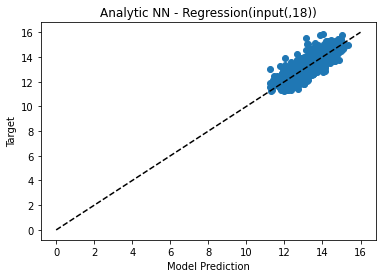

In [399]:
plt.title("Analytic NN - Regression(input(,18))")
# plt.hist(y_pre, histtype='step')
# plt.hist(np.log(np.abs(y_rg)+1), histtype='step' )
plt.xlabel("Model Prediction")
plt.ylabel("Target")
plt.scatter(y_pre,np.log(np.abs(y_rg)+1))
plt.plot([0,16],[0,16], color = 'k', linestyle='--')
# plt.xlim([0,2.5])
# plt.savefig("./plot/Regression_Scatter3.png")
# plt.savefig("./plot/DNN_Regression_Scatter1.png")
plt.savefig("./plot/FourierSeries_Scatter1.png")


plt.show()


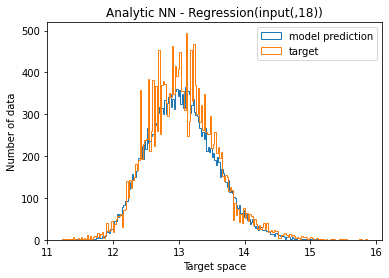

In [400]:
plt.title("Analytic NN - Regression(input(,18))")
plt.xlabel("Target space")
plt.ylabel("Number of data")
plt.hist(y_pre, histtype='step', label = "model prediction", bins = 200)
plt.hist(np.log(np.abs(y_rg)+1), histtype='step',  label = "target", bins = 200)
plt.legend()
# plt.savefig("./plot/Regression_Hist3.png")
# plt.savefig("./plot/DNN_Regression_Hist1.png")
plt.savefig("./plot/FourierSeries_Regression_Hist1.png")
# plt.xlim([0,2.5])
plt.show()

In [419]:
modelANN.save("./pre_train_models/ANN_Lite")

INFO:tensorflow:Assets written to: ./pre_train_models/ANN_Lite/assets


In [509]:
tf.keras.backend.set_floatx('float32')
inputs = tf.keras.Input(shape=(28,28))
x = inputs
print(x.shape)
x = tf.math.log(tf.math.abs(x)+1)
print(x.shape)
x = tf.keras.layers.Flatten()(x)
print(x.shape)
# x = tf.keras.layers.Flatten()(x)
# print(x.shape)
# x = Data_Selection(node = 100, num_out=20,rank=tf.rank(x))(x,x,x)
# print(x.shape)

# a = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
# b = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
# c = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
# x = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
# x = tf.squeeze(x, axis=-1)
# a = tf.squeeze(a, axis=-1)
# b = tf.squeeze(b, axis=-1)
# c = tf.squeeze(c, axis=-1)
# print("a:",a.shape)
# print(x.shape)
# a = tf.concat([x,a], axis=-1)
# b = tf.concat([x,b], axis=-1)
# c = tf.concat([x,c], axis=-1)
# print("a:",a.shape)

# a = Operator_Basis(num_out=1,rank=tf.rank(a))(a, a, a)
# b = Operator_Basis(num_out=1,rank=tf.rank(b))(b, b, b)
# c = Operator_Basis(num_out=1,rank=tf.rank(c))(c, c, c)
# print("a:",a.shape)
# a = tf.squeeze(a, axis=-1)

# x = tf.concat([x,a], axis=-1)
# b = tf.concat([b,c], axis=-1)
# print(x.shape)
# x = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
# b = Symmetry_Set_Basis(num_out=1, rank=tf.rank(b))(b, b, b)
# x = tf.squeeze(x, axis=-1)
# b = tf.squeeze(b, axis=-1)
# print(x.shape)
# x = Operator_Basis(num_out=1,rank=tf.rank(x))(x, x, x)
# b = Operator_Basis(num_out=1,rank=tf.rank(b))(b, b, b)
# print(x.shape)
# x = tf.concat([x,b], axis=-1)
# print(x.shape)

x = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
print(x.shape)

x = Operator_Basis(num_out=1,rank=tf.rank(x))(x, x, x)
print(x.shape)

# x = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
# print(x.shape)

# x = Operator_Basis(num_out=1,rank=tf.rank(x))(x, x, x)
# print(x.shape)



# x = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
# print(x.shape)

# x = Operator_Basis(num_out=1,rank=tf.rank(x))(x, x, x)
# print(x.shape)



# x = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
# a = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
# b = Symmetry_Set_Basis(num_out=1, rank=tf.rank(x))(x, x, x)
# print(x.shape)


# x = Operator_Basis(num_out=1,rank=tf.rank(x))(x, x, x)
# a = Operator_Basis(num_out=1,rank=tf.rank(a))(a, a, a)
# b = Operator_Basis(num_out=1,rank=tf.rank(b))(b, b, b)
# print(x.shape)
# x = tf.concat([x,a,b], axis=-1)
# print(x.shape)








# x = tf.keras.layers.Dense(256)(x)
# print(x.shape)
# x = tf.keras.layers.Dense(128)(x)
# print(x.shape)
# x = tf.keras.layers.Dense(32)(x)
# print(x.shape)
x = tf.keras.layers.Dense(10)(x)
print(x.shape)
x = tf.keras.layers.Activation("softmax")(x)
print(x.shape)
modelANN = tf.keras.Model(inputs= inputs, outputs=x, name='ANN')

(None, 28, 28)
(None, 28, 28)
(None, 784)
(None, 784)
(None, 784)
(None, 10)
(None, 10)


In [510]:
model_type = "ANN"
save_dir = './test1/'
model_name = '%s_model_'% model_type 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)
csv_logger = keras.callbacks.CSVLogger(save_dir+model_type+'.csv')


earlystop = keras.callbacks.EarlyStopping(
                            monitor="val_loss",
                            min_delta=1e-4,
                            patience=3, # 10
                            verbose=1,
                            mode='min', baseline=None, ## 'min' 
                            restore_best_weights=True)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=2, min_lr=0.00001)
callbacks = [checkpoint, csv_logger,  earlystop ]

In [506]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [511]:
# modelANN.compile(optimizer='adam' , loss=loss_fn, metrics=['accuracy', metrics.AUC(name="auc")])
modelANN.compile(optimizer='adam',
                 loss=loss_fn,
                 metrics=['accuracy'])
modelANN.summary()

Model: "ANN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_93 (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
tf_op_layer_Abs_3 (TensorFlo [(None, 28, 28)]          0         
_________________________________________________________________
tf_op_layer_AddV2_5 (TensorF [(None, 28, 28)]          0         
_________________________________________________________________
tf_op_layer_Log_4 (TensorFlo [(None, 28, 28)]          0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 784)               0         
_________________________________________________________________
symmetry__set__basis_139 (Sy (None, 784)               70        
_________________________________________________________________
operator__basis_71 (Operator (None, 784)               20      

In [306]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [118]:
y_train.shape


(60000,)

In [53]:
vec = np.zeros([10])

In [54]:
vec

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [69]:
y2[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [99]:
# y = [ for i in y_train]
y2 = []
for i in y_train:
    vec = np.zeros([10])    
    vec[i]=1
    y2.append(vec)
y2=np.array(y2)    
y2.shape


(60000, 10)

In [473]:
x_val = x_train[40000:]
y_val = y_train[40000:]
x_train = x_train[:40000]
y_train = y_train[:40000]

In [474]:
y_train.shape

(40000,)

In [512]:
modelANN.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks = callbacks, shuffle=True , epochs=10, batch_size=32)
# modelANN.fit(x_train, y2 , callbacks = callbacks, shuffle=True , epochs=400, batch_size=32, verbose=1)
# modelANN.fit(x_train, y_train, epochs=4)

Epoch 1/400
1250/1250 [==============================] - ETA: 0s - loss: 2.1097 - accuracy: 0.6270
Epoch 00001: val_loss improved from inf to 1.90848, saving model to ./test1/ANN_model_
INFO:tensorflow:Assets written to: ./test1/ANN_model_/assets
1250/1250 [==============================] - 29s 23ms/step - loss: 2.1097 - accuracy: 0.6270 - val_loss: 1.9085 - val_accuracy: 0.7388
Epoch 2/400
1249/1250 [============================>.] - ETA: 0s - loss: 1.7684 - accuracy: 0.8091
Epoch 00002: val_loss improved from 1.90848 to 1.69493, saving model to ./test1/ANN_model_
INFO:tensorflow:Assets written to: ./test1/ANN_model_/assets
1250/1250 [==============================] - 30s 24ms/step - loss: 1.7684 - accuracy: 0.8092 - val_loss: 1.6949 - val_accuracy: 0.8493
Epoch 3/400
1250/1250 [==============================] - ETA: 0s - loss: 1.6715 - accuracy: 0.8586
Epoch 00003: val_loss improved from 1.69493 to 1.63996, saving model to ./test1/ANN_model_
INFO:tensorflow:Assets written to: ./test1

In [521]:
y_pre.shape

(20000, 10)

In [ ]:
[for i in y_pre]

In [528]:
y_pre = [j for i in y_pre for j in range(10) if i[j]==1]

In [532]:
y_pre.shape


(20000, 10)

array([7.00000000e+00, 6.99999833e+00, 1.26924266e-22, ...,
       5.00000000e+00, 5.99999714e+00, 8.00000000e+00])

In [531]:
y_pre = modelANN.predict(x_val)
basis = np.linspace(0,9,10)
y_pre = np.sum(basis*(y_pre**2), axis=-1)

array([[0.00000000e+00, 3.22881704e-29, 4.33907548e-33, ...,
        1.00000000e+00, 2.84216566e-24, 3.79430916e-14],
       [9.28732970e-26, 7.56170243e-33, 1.88351688e-37, ...,
        9.99999881e-01, 4.03849002e-21, 6.14584650e-08],
       [1.00000000e+00, 1.04838766e-36, 6.37808476e-21, ...,
        1.40937411e-18, 1.34531557e-12, 2.05731644e-20],
       ...,
       [1.06471102e-20, 1.83538311e-24, 5.42189415e-37, ...,
        6.64631997e-20, 5.24529808e-10, 9.85660874e-17],
       [3.12992410e-10, 9.96973659e-27, 1.20822297e-13, ...,
        2.65224969e-19, 1.09845135e-17, 2.95451079e-20],
       [5.35354205e-09, 2.00367073e-22, 1.56277877e-13, ...,
        2.91524362e-16, 1.00000000e+00, 2.24257448e-08]], dtype=float32)

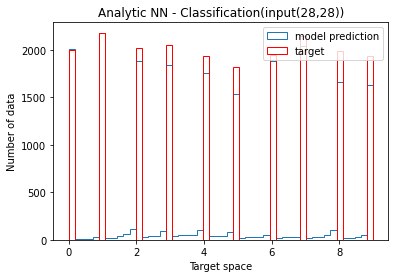

In [540]:
y_pre = modelANN.predict(x_val)
basis = np.linspace(0,9,10)
y_pre = np.sum(basis*(y_pre**2), axis=-1)
plt.title("Analytic NN - Classification(input(28,28))")
plt.xlabel("Target space")
plt.ylabel("Number of data")
plt.hist(y_pre, histtype='step', label = "model prediction", bins = 50)
plt.hist(y_val, histtype='step',  label = "target", bins = 50, color='r')
plt.legend()
plt.savefig("./plot/Classification_Hist.png")
plt.show()

In [541]:
modelANN.save("./pre_train_models/ANN_Number_Classification")

INFO:tensorflow:Assets written to: ./pre_train_models/ANN_Number_Classification/assets


## Reconstruct Analytic function

In [424]:
class Symmetry_Set_Basis_Reconstruct(tf.keras.layers.Layer):
    def __init__(self, node=7, num_out=1, rank=2, weights = [[],[],[],[]]):
        super(Symmetry_Set_Basis_Reconstruct, self).__init__()
        self.node = node
        self.wq = tf.keras.layers.Dense(node, weights = [weights[0], weights[1]])
        self.wk = tf.keras.layers.Dense(node, weights = [weights[2], weights[3]])
        self.num_out = num_out
        self.p = [[0,2,1],[0,1,3,2], [0,1,2,4,3], [0,1,2,3,5,4]][rank-2]
        self.rui = tf.random_uniform_initializer(minval=-10, maxval=10)
    
    def Tile_reshape(self, cn):
        a = cn.shape
        b = tf.zeros(tf.rank(cn))+1
        b = tf.cast(b,tf.int32)
        a = tf.concat([b[:-1],b[-1:]*tf.constant(a[-1], tf.int32)], -1)
        return a
    def VP(self, m, cn): # m: order,  cn: input tensor, k: range
        vp = tf.math.pow(cn,m)
        vp = tf.reduce_sum(vp, axis = -1)
        vp = tf.expand_dims(vp, axis = -1)
        vp = tf.tile(vp, self.Tile_reshape(cn))
        return vp
    
    def VC1(self, cn):
        
        vc = tf.reduce_sum(cn, axis = -1)
        vc = tf.expand_dims(vc, axis=-1)
        vc = tf.tile(vc, self.Tile_reshape(cn))
        return vc
    def VC2(self, cn):
        vc = (self.VC1(cn)**2 - self.VP(2, cn))/2
        return vc
    def VC3(self, cn):
        vc1 = self.VC1(cn)
        vp2 = self.VP(2,cn)
        vp3 = self.VP(3,cn)
        vc = (vc1**3-vp3-3*(vp2 * vc1-vp3 ))/6
        return vc
    def VC4(self, cn):
        vc = (self.VC3(cn)*self.VP(1,cn) - self.VC2(cn)*self.VP(2,cn) + self.VC1(cn)*self.VP(3,cn) - self.VP(4,cn) )/4
        return vc
    
    def call(self, q, k, v):
        vc1 = self.VC1(v)
        vc2 = self.VC2(v)
        vc3 = self.VC3(v)
        vc4 = self.VC4(v)
        vp2 = self.VP(2,v)
        vp3 = self.VP(3,v)
        vp4 = self.VP(4,v)
##--------------------------------------------------------
        vc2 = tf.math.pow(tf.math.abs(vc2),1/2)*tf.math.sign(vc2)
        vc3 = tf.math.pow(tf.math.abs(vc3),1/3)*tf.math.sign(vc3)
        vc4 = tf.math.pow(tf.math.abs(vc4),1/4)*tf.math.sign(vc4)
        vp2 = tf.math.pow(tf.math.abs(vp2),1/2)*tf.math.sign(vp2)
        vp3 = tf.math.pow(tf.math.abs(vp3),1/3)*tf.math.sign(vp3)
        vp4 = tf.math.pow(tf.math.abs(vp4),1/4)*tf.math.sign(vp4)


##----------------------------------------------------------


        vc1 = tf.expand_dims(vc1, axis=-1)
        vc2 = tf.expand_dims(vc2, axis=-1)
        vc3 = tf.expand_dims(vc3, axis=-1)
        vc4 = tf.expand_dims(vc4, axis=-1)
        vp2 = tf.expand_dims(vp2, axis=-1)
        vp3 = tf.expand_dims(vp3, axis=-1)
        vp4 = tf.expand_dims(vp4, axis=-1)

        v = tf.concat([vc1, vc2, vc3, vc4, vp2, vp3, vp4], axis =-1)
        q = tf.expand_dims(q, axis=-1)
        q = self.wq(q)
        q = tf.transpose(q, perm=self.p) 
        k = self.wk(v)
        k = tf.transpose(k, perm=self.p) 
        k = k/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(k,2) ,axis=-1))+1e-10, axis=-1)
        q = q/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(q,2) ,axis=-1))+1e-10, axis=-1)
##-----------------------------------------------------------------------------------------
        n = tf.math.multiply_no_nan(k,q)
##--------------------------------------------------sum all v*n version ------------------------------------------
        n = tf.transpose(n, perm=self.p)
        v = tf.math.multiply_no_nan(n,v)
        v = tf.reduce_sum(v, axis=-1)

        return v, n
        
class Operator_Basis_Reconstruct(tf.keras.layers.Layer):
    def __init__(self, node=3, num_out=1, rank=2, weights = [[],[],[],[],[],[]]):
        super(Operator_Basis_Reconstruct, self).__init__()
        self.node = node
        self.wq = tf.keras.layers.Dense(node, weights = [weights[0], weights[1]])
        self.wk = tf.keras.layers.Dense(node, weights = [weights[2], weights[3]])
        self.alpha = tf.keras.layers.Dense(1, weights = [weights[4], weights[5]])
        self.num_out = num_out
        self.p = [[0,2,1],[0,1,3,2], [0,1,2,4,3], [0,1,2,3,5,4]][rank-2]
    
    def call(self, q, k, v):
        sqrt = tf.math.sqrt(tf.math.abs(v)+1e-10)
        ln = tf.math.log(tf.math.abs(v)+1)
#         exp = tf.math.exp(v)
        rgsn = self.alpha(tf.expand_dims(v, axis=-1))
        
        sqrt= tf.expand_dims(sqrt, axis=-1)
        ln = tf.expand_dims(ln, axis=-1)
#         exp = tf.expand_dims(exp, axis=-1)

#         v = tf.concat([sqrt, ln, exp, rgsn], axis =-1)
        v = tf.concat([sqrt, ln, rgsn], axis =-1)
        q = tf.expand_dims(q, axis=-1)
        q = self.wq(q)
        q = tf.transpose(q, perm=self.p) 
        k = self.wk(v)
        k = tf.transpose(k, perm=self.p) 
        k = k/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(k,2)+1e-10 ,axis=-1)), axis=-1)
        q = q/tf.expand_dims(tf.math.sqrt(tf.reduce_sum(tf.math.pow(q,2)+1e-10 ,axis=-1)), axis=-1)
    

        n = tf.math.multiply_no_nan(k,q)
        n = tf.transpose(n, perm=self.p) 
##--------------------------------------------------sum all v*n version ------------------------------------------
        v = tf.math.multiply_no_nan(n,v)
        v = tf.reduce_sum(v, axis=-1)

##----------------------------------------------------------------------------------------------
        return v, n, self.alpha.weights
        

def Selection_Reconstruct(n, r = 0.01, ind=[False]):
    n = tf.reduce_mean(n,axis=0)
#     n = tf.reduce_sum(n, axis=0)
    sl1 = tf.reduce_max(tf.math.abs(n), axis = -1)
    sl1 = sl1.numpy()
    node = len(sl1)
    dl = np.max(np.abs(sl1))*r
    index = np.linspace(0, node-1, node)[np.abs(sl1)>dl] 

    index = (set(ind))&(set(index)) if np.any(ind) else index

    index = np.array(list(index))
    index = index.astype(np.int32)
    n = n.numpy()
    n = np.take(n, index, axis=0)
#     n = np.sum(n, axis = 0)
    return n, index
def rgsn_Reconstruct(rgsn):
    return tf.squeeze(rgsn[0]).numpy(), tf.squeeze(rgsn[1]).numpy() # weight, bias

def Out_Analytic_Set(x, n, index, rgsnw=1, rgsnb=0, mode = "SSB", digits=2):
    n = np.around(n, digits)
    rgsnw = np.around(rgsnw, digits)
    rgsnb = np.around(rgsnb, digits)
    n = n.astype(np.str)
    SSB_keys = ["vc1", "vc2", "vc3", "vc4", "vp2", "vp3", "vp4"]
    OB_keys = ["sqrt", "ln", "rgsn"]
    x0 = np.empty(x.shape, dtype=np.str) 
    x0 = x0.astype(np.dtype('<U1000'))
    for i in range(len(x)):
        if i in index:
            
            w = np.take(n, np.linspace(0, len(index)-1, len(index))[index==i].astype(np.int32), axis=0)
            w = w.astype(np.str)
            w = np.squeeze(w)
            if mode == "SSB":
                for j in range(len(SSB_keys)):
                    x0[i] =x0[i] +"+"+ w[j]+"*"+SSB_keys[j]+"("+x[i]+")"
            if mode == "OB":
                for j in range(len(OB_keys)):
                    if OB_keys[j] == "rgsn":
                        x0[i] = x0[i]+"+" + w[j]+"*"+str(rgsnw)+"*"+"("+x[i]+")"+str(rgsnb)
                    else:
                        x0[i] = x0[i]+"+" + w[j]+"*"+OB_keys[j]+"("+x[i]+")"
    return x0
                    
# def Dense_Reconstruct(w, b, ind):
    
    


        
        


In [313]:
test.layers[3].get_weights()[0].shape

(18, 1)

In [420]:
# test = tf.keras.models.load_model("./pre_train_models/ANN")
test = tf.keras.models.load_model("./pre_train_models/ANN_Lite")

In [421]:
test.layers

In [276]:
Symmetry_Set_Basis_Reconstruct(num_out=1, rank=tf.rank(x), weights =test.layers[1].get_weights() )

In [426]:
a

array(['', '', '',
       '+-0.03*sqrt(+0.03*vc1()+0.03*vc2()+0.03*vc3()+0.03*vc4()+0.03*vp2()+-0.03*vp3()+0.03*vp4())+-0.03*ln(+0.03*vc1()+0.03*vc2()+0.03*vc3()+0.03*vc4()+0.03*vp2()+-0.03*vp3()+0.03*vp4())+-0.03*1.15*(+0.03*vc1()+0.03*vc2()+0.03*vc3()+0.03*vc4()+0.03*vp2()+-0.03*vp3()+0.03*vp4())-0.04',
       '', '', '', '', '', '', '', '', '',
       '+-0.95*sqrt(+0.23*vc1()+0.23*vc2()+0.23*vc3()+0.23*vc4()+0.23*vp2()+-0.23*vp3()+0.23*vp4())+-0.95*ln(+0.23*vc1()+0.23*vc2()+0.23*vc3()+0.23*vc4()+0.23*vp2()+-0.23*vp3()+0.23*vp4())+-0.95*1.15*(+0.23*vc1()+0.23*vc2()+0.23*vc3()+0.23*vc4()+0.23*vp2()+-0.23*vp3()+0.23*vp4())-0.04',
       '', '', '',
       '+-0.02*sqrt(+0.02*vc1()+0.02*vc2()+0.02*vc3()+0.02*vc4()+0.02*vp2()+-0.02*vp3()+0.02*vp4())+-0.02*ln(+0.02*vc1()+0.02*vc2()+0.02*vc3()+0.02*vc4()+0.02*vp2()+-0.02*vp3()+0.02*vp4())+-0.02*1.15*(+0.02*vc1()+0.02*vc2()+0.02*vc3()+0.02*vc4()+0.02*vp2()+-0.02*vp3()+0.02*vp4())-0.04'],
      dtype='<U1000')

In [ ]:
def: K = vc1+vc2+vc3+vc4+vp2-vp3+vp4
-sqrt(0.23*K) -ln(0.23*K)-1.2*K-0.4


In [425]:
a = np.empty([18], dtype=np.str)
x, y = tf.constant(x_rg), tf.constant(y_rg)
x, n = Symmetry_Set_Basis_Reconstruct(num_out=1, rank=tf.rank(x), weights =test.layers[1].get_weights())(x, x, x)
n1, ind1 = Selection_Reconstruct(n)
a = Out_Analytic_Set(a, n1, ind1, rgsnw=1, rgsnb=0, mode = "SSB")
x, n, rgsn = Operator_Basis_Reconstruct(num_out=1,rank=tf.rank(x), weights =test.layers[2].get_weights())(x, x, x)
n2, ind2 = Selection_Reconstruct(n, ind=ind1)
rgsnw1, rgsnb1 = rgsn_Reconstruct(rgsn)
a = Out_Analytic_Set(a, n2, ind2, rgsnw=rgsnw1, rgsnb=rgsnb1, mode = "OB")

# x, n = Symmetry_Set_Basis_Reconstruct(num_out=1, rank=tf.rank(x), weights =test.layers[3].get_weights())(x, x, x)
# n1, ind1 = Selection_Reconstruct(n, ind=ind2)
# a = Out_Analytic_Set(a, n1, ind1, rgsnw=1, rgsnb=0, mode = "SSB")
# x, n, rgsn = Operator_Basis_Reconstruct(num_out=1,rank=tf.rank(x), weights =test.layers[4].get_weights())(x, x, x)
# n2, ind2 = Selection_Reconstruct(n, ind=ind1)
# rgsnw1, rgsnb1 = rgsn_Reconstruct(rgsn)
# a = Out_Analytic_Set(a, n2, ind2, rgsnw=rgsnw1, rgsnb=rgsnb1, mode = "OB")

# x = tf.keras.layers.Dense(1, weights =test.layers[5].get_weights())(x)




In [229]:
a

array(['', '', '', '0.0287*sqrt(0.0265*vc1()0.0225*v', '', '', '', '', '',
       '', '', '', '', '0.9497*sqrt(0.2281*vc1()0.1196*v', '', '', '',
       '0.0203*sqrt(0.024*vc1()0.0199*vc'], dtype='<U32')

In [ ]:

x = Operator_Basis_Reconstruct(num_out=1,rank=tf.rank(x))(x, x, x)
print(x.shape)
x = Symmetry_Set_Basis_Reconstruct(num_out=1, rank=tf.rank(x))(x, x, x)
print(x.shape)
x = Operator_Basis_Reconstruct(num_out=1,rank=tf.rank(x))(x, x, x)
print(x.shape)
x = tf.keras.layers.Dense(1)(x)
print(x.shape)

modelANN = tf.keras.Model(inputs= inputs, outputs=x, name='ANN')

In [ ]:
modelANN.weights

In [525]:
from sklearn.metrics import roc_curve, auc

In [527]:
y_score = modelANN.predict(x_val)[:,0]
y_score = np.hstack(y_score)
# test=[i[1] for i in yim_test]
fpr , tpr , thresholds = roc_curve ( y_val , y_score)
roc_auc = auc(tpr,fpr )
print("The area under the curves are:")
print("AUC:{0:.9f}".format(roc_auc))
if roc_auc<0.5:
    a = tpr
    tpr = fpr
    fpr = a
    roc_auc = 1 - roc_auc
    print("AUC:{0:.9f}".format(roc_auc))
    
# FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test,Predictions)
plt.figure(figsize=(8,8))

plt.plot(tpr,fpr, label='Fully supervised: AUC={0:.5f}'.format(roc_auc))
plt.ylabel('False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
# plt.legend()
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)

plt.legend(prop={'size': 14})
plt.show()

ValueError: multiclass format is not supported

In [ ]:
# Selection Block
class Selection(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(Selection, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        
#         self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        
        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
        return output, attention_weights


## Optimize

In [13]:
# x_(t+1) = x_t - lr*grad.(f(x_t))

opt = tf.keras.optimizers.Adam(learning_rate=0.1)
var1 = tf.Variable(10.0)
loss = lambda: (var1 ** 2)/2.0       # d(loss)/d(var1) == var1
step_count = opt.minimize(loss, [var1]).numpy()
# The first step is `-learning_rate*sign(grad)`
var1.numpy()

9.9

In [45]:
while var1.numpy()>0.1:
    opt.minimize(loss, [var1]).numpy()
    print(var1.numpy())

0.9540412
0.9305041
0.90742856
0.8848088
0.862639
0.8409134
0.8196262
0.79877156
0.7783437
0.7583367
0.73874485
0.7195623
0.70078325
0.68240196
0.66441256
0.64680934
0.6295866
0.6127385
0.59625936
0.5801435
0.5643853
0.54897904
0.5339191
0.5191999
0.50481594
0.4907616
0.47703144
0.46361995
0.4505217
0.43773136
0.4252435
0.41305286
0.40115413
0.3895421
0.3782116
0.36715743
0.35637453
0.34585783
0.33560234
0.3256031
0.3158552
0.30635378
0.29709405
0.28807122
0.2792806
0.2707176
0.26237753
0.25425592
0.24634825
0.23865008
0.23115706
0.22386485
0.21676919
0.20986587
0.20315073
0.1966197
0.19026873
0.18409383
0.1780911
0.17225665
0.16658668
0.16107745
0.15572527
0.1505265
0.14547755
0.14057492
0.13581514
0.13119482
0.12671058
0.12235916
0.11813731
0.11404186
0.11006968
0.10621771
0.102482945
0.09886242


In [53]:
a = tf.constant([[1,1],[2,2],[3,3]])
a.numpy()

array([[1, 1],
       [2, 2],
       [3, 3]], dtype=int32)

In [55]:
tf.math.pow(a,2)

<tf.Tensor: shape=(3, 2), dtype=int32, numpy=
array([[1, 1],
       [4, 4],
       [9, 9]], dtype=int32)>

In [57]:
tf.reduce_sum(a, axis=-1)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([2, 4, 6], dtype=int32)>

# 

## Symmetry Variables Function

In [132]:
## Note: m<=n
def find_N(cn):
    a = cn.shape
    a = tf.constant(a)
    n = a[-1:].numpy()
    n = n[0]
    return n

def Tile_reshape(cn):
    a = cn.shape
    a = tf.constant(a)
    b = a*0+1
    a = tf.concat([b[:-1],b[-1:]*tf.constant(a[-1])], -1)
    return a
def VP(m, cn): # m: order,  cn: input tensor, k: range
    cn = tf.cast(cn, tf.float64)
    vp = tf.math.pow(cn,m)
    vp = tf.reduce_sum(vp, axis = -1)
    vp = tf.expand_dims(vp, axis = -1)
    vp = tf.tile(vp, Tile_reshape(cn))
    return vp
 
def VC1(cn):
    vc = tf.reduce_sum(cn, axis = -1)
    vc = tf.expand_dims(vc, axis=-1)
    vc = tf.tile(vc, Tile_reshape(cn))
    vc = tf.cast(vc, tf.float64)
    return vc
def VC2(cn):
    vc = (VC1(cn)**2 - VP(2, cn))/2
    return vc
def VC3(cn):
    vc1 = VC1(cn)
    vp2 = VP(2,cn)
    vp3 = VP(3,cn)
    vc = (vc1**3-vp3-3*(vp2 * vc1-vp3 ))/6
    return vc
def VC4(cn):
    n = find_N(cn)
#     vc = (VC3(cn)*VP(0,cn) - 3/(n-2)*VC2(cn)*VP(1,cn) + 3/(n-2)*2/(n-1)*VC1(cn)*VP(3,cn) - 3/(n-2)*2/(n-1)*VP(4,cn) )/(n-3)
    vc = (VC3(cn)*VP(1,cn) - VC2(cn)*VP(2,cn) + VC1(cn)*VP(3,cn) - VP(4,cn) )/4
    return vc

## VCN: 
# vcn = 0
# for i in range(N):
#     vcn += VC(N-i-1)VP(i+1)*(-1)**i
# vcn = vcn/N

In [130]:
def Con(n,k):
    fc=1
    for i in range(k):
        fc *=(n-i)
        fc /= (i+1)
    return fc
def text(cn):
    vc = (VC2(cn)*VP(1, cn) - VC1(cn)*VP(2,cn) + VP(3,cn))/3
    return vc

In [120]:
Con(5,3)

10.0

In [58]:
VC3(cn).dtype

tf.float64

In [92]:
a = cn.shape
a = tf.constant(a)
n = a[-1:].numpy()
n[0]

5

In [134]:
text(cn)

<tf.Tensor: shape=(3, 5), dtype=float64, numpy=
array([[ 225.,  225.,  225.,  225.,  225.],
       [  10.,   10.,   10.,   10.,   10.],
       [1175., 1175., 1175., 1175., 1175.]])>

In [135]:
VC3(cn)

<tf.Tensor: shape=(3, 5), dtype=float64, numpy=
array([[ 225.,  225.,  225.,  225.,  225.],
       [  10.,   10.,   10.,   10.,   10.],
       [1175., 1175., 1175., 1175., 1175.]])>

In [128]:
cn = tf.constant([[1,2,3,4,5],[1,1,1,1,1],[3,4,5,6,7]])
# cn = tf.constant([[1,2,3,4],[1,1,1,1],[3,4,5,6]])

# cn.numpy()
VC4(cn).numpy()

array([[ 561.5,  561.5,  561.5,  561.5,  561.5],
       [   5. ,    5. ,    5. ,    5. ,    5. ],
       [3616.5, 3616.5, 3616.5, 3616.5, 3616.5]])

In [112]:
N=5
fc=1
for i in range(N):
    fc*=(i+1)
    
a = 0
for i in range(N):
    a += fc/(i+1)

In [113]:
a

274.0

In [52]:
tf.math.multiply(VC3(cn),VC1(cn))

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a double tensor but is a int32 tensor [Op:Mul]

In [26]:
a = cn.shape
a = tf.constant(a)
b = a*0+1
a = tf.concat([b[:-1],b[-1:]*tf.constant(a[-1])], -1)
a

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 2], dtype=int32)>

In [22]:
a[-1:]

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>

In [11]:
tf.tile(cn, [1,2])

<tf.Tensor: shape=(3, 4), dtype=int32, numpy=
array([[1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3]], dtype=int32)>